### *IPCC SR15 scenario assessment*

<img style="float: right; height: 80px; padding-left: 20px;" src="../_static/IIASA_logo.png">
<img style="float: right; height: 80px;" src="../_static/IAMC_logo.jpg">

# Characteristics of four illustrative model pathways
## Figure 3b of the *Summary for Policymakers*

This notebook derives the figure panels and indicators for the table in Figure 3b in the Summary for Policymakers
of the IPCC's _"Special Report on Global Warming of 1.5°C"_.

The scenario data used in this analysis can be accessed and downloaded at [https://data.ene.iiasa.ac.at/iamc-1.5c-explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer).

## Load `pyam` package and other dependencies

In [1]:
import pandas as pd
import numpy as np
import io
import itertools
import yaml
import math
import matplotlib.pyplot as plt
plt.style.use('style_sr15.mplstyle')
%matplotlib inline
import pyam

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Import scenario data, categorization and specifications files

The metadata file with scenario categorisation and quantitative indicators can be downloaded at [https://data.ene.iiasa.ac.at/iamc-1.5c-explorer](https://data.ene.iiasa.ac.at/iamc-1.5c-explorer).  
Alternatively, it can be re-created using the notebook `sr15_2.0_categories_indicators`.

The last cell of this section loads and assigns a number of auxiliary lists as defined in the categorization notebook.

In [2]:
sr1p5 = pyam.IamDataFrame(data='../data/iamc15_scenario_data_world_r2.0.xlsx')

pyam.utils - INFO: Reading `../data/iamc15_scenario_data_world_r2.0.xlsx`


In [3]:
sr1p5.load_meta('sr15_metadata_indicators.xlsx')

pyam.core - INFO: Importing metadata for 416 scenarios (for total of 416)


In [4]:
with open("sr15_specs.yaml", 'r') as stream:
    specs = yaml.load(stream, Loader=yaml.FullLoader)

rc = pyam.run_control()
for item in specs.pop('run_control').items():
    rc.update({item[0]: item[1]})
cats_15 = specs.pop('cats_15')
cats_15_no_lo = specs.pop('cats_15_no_lo')
marker = specs.pop('marker')

## Downselect scenario ensemble to categories of interest for this assessment

In [5]:
sr1p5.meta.rename(columns={'Kyoto-GHG|2010 (SAR)': 'kyoto_ghg_2010'}, inplace=True)

In [6]:
df = sr1p5.filter(category=cats_15)

## Global carbon dioxide emissions in four illustrative pathways

Figure SPM3b shows the contribution to CO2 emissions and removal by three categories in the four illustrative pathways.

This illustration does not use the emissions timeseries as reported by the models. This is because the variable `Emissions|CO2|Energy and Industrial Processes` represents net emissions, incorporating carbon dioxide removal in this sector.

The steps below compute the gross emissions. The long variable names are mapped to short variables for easier readibility.

In [7]:
afolu_var = 'Emissions|CO2|AFOLU'
ene_ind_var = 'Emissions|CO2|Energy and Industrial Processes'
beccs_var ='Carbon Sequestration|CCS|Biomass'

We downselect the entire data to the four illustrative pathways (`marker` scenarios) and the three variables of interest. For consistency with the figure in the SPM, the units are converted to Gt CO2.

In [8]:
pw = df.filter(marker=marker, variable=[afolu_var, ene_ind_var, beccs_var],
               year=range(2010, 2101, 10))

In [9]:
pw.convert_unit('Mt CO2/yr', 'Gt CO2/yr', inplace=True)

As a first step, we extract the timeseries for the AFOLU emissions and rename the variable for brevity. This data will be used as is in this figure.

In [10]:
afolu = (
    pw.filter(variable=afolu_var)
    .rename(variable={afolu_var: 'AFOLU'})
)

The energy-and-industry and BECCS timeseries data needs some processing. It is first separated into two distinct dataframes, and the BECCS variable is renamed for brevity.

In [11]:
ene_ind = pw.filter(variable=ene_ind_var)

In [12]:
beccs = (
    pw.filter(variable=beccs_var)
   .rename(variable={beccs_var: 'BECCS'})
)

The variable `Carbon Sequestration|CCS|Biomass` reports removed carbon dioxide as positive values. For use in this figure, the sign needs to be reversed.

In [13]:
beccs.data.value = - beccs.data.value

The `LED` marker scenario does not use any BECCS by assumption of the scenario design. For this reason, the variable `Carbon Sequestration|CCS|Biomass` was not defined when the MESSAGE team submitted the scenario results to the IAMC 1.5°C Scenario Data ensemble.

For easier computation, we add this data series manually here.

In [14]:
years = beccs.timeseries().columns

In [15]:
beccs.append(
    pyam.IamDataFrame(
        pd.DataFrame([0] * len(years), index=years).T,
        model='MESSAGEix-GLOBIOM 1.0', scenario='LowEnergyDemand',
        region='World', variable='BECCS', unit='Gt CO2/yr'),
    inplace=True
)

As a third step, we compute the difference between net CO2 emissions from the energy sector & industry and BECCS to obtain gross CO2 emissions in that sector.

In [16]:
def get_value(df):
    cols = ['model', 'scenario', 'region', 'year', 'unit']
    return df.data.set_index(cols)['value']

In [17]:
diff = get_value(ene_ind) - get_value(beccs)

In [18]:
ene_ind_gross = pyam.IamDataFrame(diff, variable='Fossil fuel and industry')

We now combine the three contribution dataframes into one joint dataframe for plotting. Because the `beccs` IamDataFrame was partially altered, concatenating directly causes an issue, so we remove all `meta` columns from that dataframe beforehand.

In [19]:
beccs.meta = beccs.meta.drop(columns=beccs.meta.columns)

In [20]:
co2 = pyam.concat([ene_ind_gross, afolu, beccs])

We now proceed to plot the four illustrative pathways.

/Users/aa/.pyenv_intel/versions/anaconda3-2018.12/envs/iam-original/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aa/.pyenv_intel/versions/anaconda3-2018.12/envs/iam-original/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


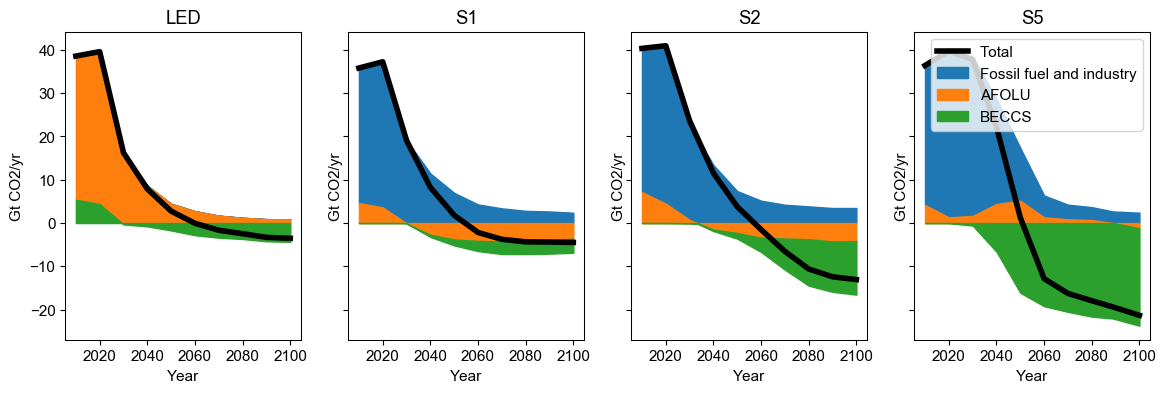

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4), sharey=True)

for i, m in enumerate(['LED', 'S1', 'S2', 'S5']):
    co2.filter(marker=m).stack_plot(ax=ax[i], total=True, legend=False)
    ax[i].title.set_text(m)

ax[3].legend(loc=1)

## Collecting indicators across illustrative pathways

### Initialize a `pyam.Statistics` instance

In [22]:
base_year = 2010
compare_years = [2030, 2050]
years = [base_year] + compare_years

In [23]:
stats = pyam.Statistics(df=df, groupby={'marker': ['LED', 'S1', 'S2', 'S5']},
                        filters=[(('pathways', 'no & lo os 1.5'), {'category': cats_15_no_lo})])

### CO2 and Kyoto GHG emissions reductions

In [24]:
co2 = (
    df.filter(kyoto_ghg_2010='in range', variable='Emissions|CO2', year=years)
    .convert_unit('Mt CO2/yr', 'Gt CO2/yr')
    .timeseries()
)

In [25]:
for y in compare_years:
    stats.add((co2[y] / co2[2010] - 1) * 100,
        'CO2 emission reduction (% relative to 2010)',
        subheader=y)

In [26]:
kyoto_ghg = (
    df.filter(kyoto_ghg_2010='in range', variable='Emissions|Kyoto Gases (SAR-GWP100)', year=years)
    .rename(unit={'Mt CO2-equiv/yr': 'Mt CO2e/yr'})
    .convert_unit('Mt CO2e/yr','Gt CO2e/yr')
    .timeseries()
)
for y in compare_years:
    stats.add((kyoto_ghg[y] / kyoto_ghg[base_year] - 1) * 100,
        'Kyoto-GHG emission reduction (SAR-GWP100), % relative to {})'.format(base_year),
        subheader=y)

### Final energy demand reduction relative to 2010

In [27]:
fe = df.filter(variable='Final Energy', year=years).timeseries()
for y in compare_years:
    stats.add((fe[y] / fe[base_year] - 1) * 100,
              'Final energy demand reduction relative to {} (%)'.format(base_year),
              subheader=y)

### Share of renewables in electricity generation

In [28]:
def add_stats_share(stats, var_list, name, total, total_name, years, df=df):

    _df = df.filter(variable=var_list)
    for v in var_list:
        _df.require_variable(v, exclude_on_fail=True)
    _df.filter(exclude=False, inplace=True)

    component = (
        _df.timeseries()
        .groupby(['model', 'scenario']).sum()
    )
    share = component / total * 100
    
    for y in years:
        stats.add(share[y], header='Share of {} in {} (%)'.format(name, total_name),
                  subheader=y)

In [29]:
ele = df.filter(variable='Secondary Energy|Electricity', year=compare_years).timeseries()
ele.index = ele.index.droplevel([2, 3, 4])

In [30]:
ele_re_vars = [
    'Secondary Energy|Electricity|Biomass',
    'Secondary Energy|Electricity|Non-Biomass Renewables'
]
add_stats_share(stats, ele_re_vars, 'renewables', ele, 'electricity', compare_years)

pyam.core - INFO: All scenarios have the required variable `Secondary Energy|Electricity|Biomass`
pyam.core - INFO: All scenarios have the required variable `Secondary Energy|Electricity|Non-Biomass Renewables`


### Changes in primary energy mix

In [31]:
mapping = [
    ('coal', 'Coal'),
    ('oil', 'Oil'),
    ('gas', 'Gas'),
    ('nuclear', 'Nuclear'),
    ('bioenergy', 'Biomass'),
    ('non-biomass renewables', 'Non-Biomass Renewables')
]

In [32]:
for (n, v) in mapping:
    data = df.filter(variable='Primary Energy|{}'.format(v), year=years).timeseries()

    for y in compare_years:
        stats.add((data[y] / data[base_year] - 1) * 100,
                  header='Primary energy from {} (% rel to {})'.format(n, base_year),
                  subheader=y)

###  Cumulative carbon capture and sequestration until the end of the century

In [33]:
def cumulative_ccs(variable, name, first_year=2016, last_year=2100):

    data = (
        df.filter(variable=variable)
        .convert_unit('Mt CO2/yr', 'Gt CO2/yr')
        .timeseries()
    )
    
    stats.add(
        data.apply(pyam.cumulative, raw=False, axis=1,
                   first_year=first_year, last_year=last_year),
        header='Cumulative {} until {} (GtCO2)'.format(name, last_year), subheader='')

In [34]:
cumulative_ccs('Carbon Sequestration|CCS', 'CCS')

In [35]:
cumulative_ccs('Carbon Sequestration|CCS|Biomass', 'BECCS')

### Land cover for energy crops

Convert unit to SI unit (million square kilometers).

In [36]:
energy_crops = (
    df.filter(variable='Land Cover|Cropland|Energy Crops', year=2050)
    .convert_unit('million ha', 'million km2', factor=0.01)
    .timeseries()
)

In [37]:
stats.add(energy_crops[2050], header='Land are for energy crops (million km2)')

### Emissions from land use

In [38]:
species = ['CH4', 'N2O']

In [39]:
for n in species:
    data = df.filter(kyoto_ghg_2010='in range', variable='Emissions|{}|AFOLU'.format(n), year=years).timeseries()

    for y in compare_years:
        stats.add((data[y] / data[base_year] - 1) * 100,
                  header='Agricultural {} emissions (% rel to {})'.format(n, base_year),
                  subheader=y)

## Display summary statistics and export to `xlsx`

In [40]:
summary = stats.summarize(interquartile=True, custom_format='{:.0f}').T
summary

marker  \
                                                                                 LED   
                                                   mean (interquartile range)          
count                                                                                  
CO2 emission reduction (% relative to 2010)        2030                          -58   
                                                   2050                          -93   
Kyoto-GHG emission reduction (SAR-GWP100), % re... 2030                          -50   
                                                   2050                          -82   
Final energy demand reduction relative to 2010 (%) 2030                          -15   
                                                   2050                          -32   
Share of renewables in electricity (%)             2030                           60   
                                                   2050                           77   
Primary energy from coal (% rel to 2010)           2030                          -78   
                                                   2050                          -97   
Primary energy from oil (% rel to 2010)            2030                          -37   
                                                   2050                          -87   
Primary energy from gas (% rel to 2010)            2030                          -25   
                                                   2050                          -74   
Primary energy from nuclear (% rel to 2010)        2030                           59   
                                                   2050                          150   
Primary energy from bioenergy (% rel to 2010)      2030                          -11   
                                                   2050                          -16   
Primary energy from non-biomass renewables (% r... 2030                          430   
                                                   2050                          833   
Cumulative CCS until 2100 (GtCO2)                                                  0   
Cumulative BECCS until 2100 (GtCO2)                                                    
Land are for energy crops (million km2)            2050                            0   
Agricultural CH4 emissions (% rel to 2010)         2030                          -24   
                                                   2050                          -33   
Agricultural N2O emissions (% rel to 2010)         2030                            5   
                                                   2050                            6   

                                                                                     \
                                                                                 S1   
                                                   mean (interquartile range)         
count                                                                                 
CO2 emission reduction (% relative to 2010)        2030                         -47   
                                                   2050                         -95   
Kyoto-GHG emission reduction (SAR-GWP100), % re... 2030                         -49   
                                                   2050                         -89   
Final energy demand reduction relative to 2010 (%) 2030                          -5   
                                                   2050                           2   
Share of renewables in electricity (%)             2030                          58   
                                                   2050                          81   
Primary energy from coal (% rel to 2010)           2030                         -61   
                                                   2050                         -77   
Primary energy from oil (% rel to 2010)            2030                         -13   
                                            

In [41]:
summary.to_excel('output/spm_sr15_figure3b_indicators_table.xlsx')